# TL;DR

- change or changepoint detection methods are used to locates changes in distribution of a data series, usually over time
- there's a bunch of methods; some characteristics are:
    - online/offline
    - number of periods known or not
- here we consider only the PELT (pruned exact linear time) algorithm which is an offline method
- it is part of "state-of-the-art" package aptly named `changepoint`
- it works well on standard data
- some work is needed with the penalty for non-standard distributions

# Setup

In [18]:
library(changepoint)
library(data.table)
library(ggplot2)

options(repr.plot.width = 15, repr.plot.height = 12)

# Simulated data

## Example 1

In this example we create an artificial poisson-distributed data with multiple regime changes. The regime changes are well-defined so we expect a good match between the changepoint detection and the actual changes we generated.

This function creates the generative data of our experiment:

In [2]:
make_generative_data <- function(N, np, mu, sigma, seed=1) {
    set.seed(seed)

    ## for this we draw np-1 uniform values between 1 and N
    period_limits <- sort(as.integer(runif(np-1, 1, N)))

    period_start <- c(0, period_limits)
    period_end <- c(period_limits, N)

    ## we draw from a half-normal distribution:
    lambda <- as.integer(abs(rnorm(np, mu, sigma)))

    data.table(period_nb=as.factor(1:np), period_start, period_end, period_length=period_end-period_start, lambda)
}

Now we proceed to create the generative data:

In [3]:
## let's look at `N` days of data
N <- 365

## we imagine `np` periods in this data
np <- 5

## the Poisson mean for each period
mu <- 25
sigma <- 25

generative_data <- make_generative_data(N, np, mu, sigma)

generative_data

period_nb,period_start,period_end,period_length,lambda
<fct>,<dbl>,<dbl>,<dbl>,<int>
1,0,97,97,4
2,97,136,39,64
3,136,209,73,33
4,209,331,122,4
5,331,365,34,37


Now we create the actual experiment data:

In [4]:
generate <- function(dt) data.table(lambda=dt$lambda, count=rpois(dt$period_length, dt$lambda))

data <- data.table(x=1:N, generative_data[, generate(.SD), by=period_nb])

print(data, topn=5)

       x period_nb lambda count
  1:   1         1      4     5
  2:   2         1      4     4
  3:   3         1      4     5
  4:   4         1      4    10
  5:   5         1      4     3
 ---                           
361: 361         5     37    29
362: 362         5     37    39
363: 363         5     37    43
364: 364         5     37    34
365: 365         5     37    26


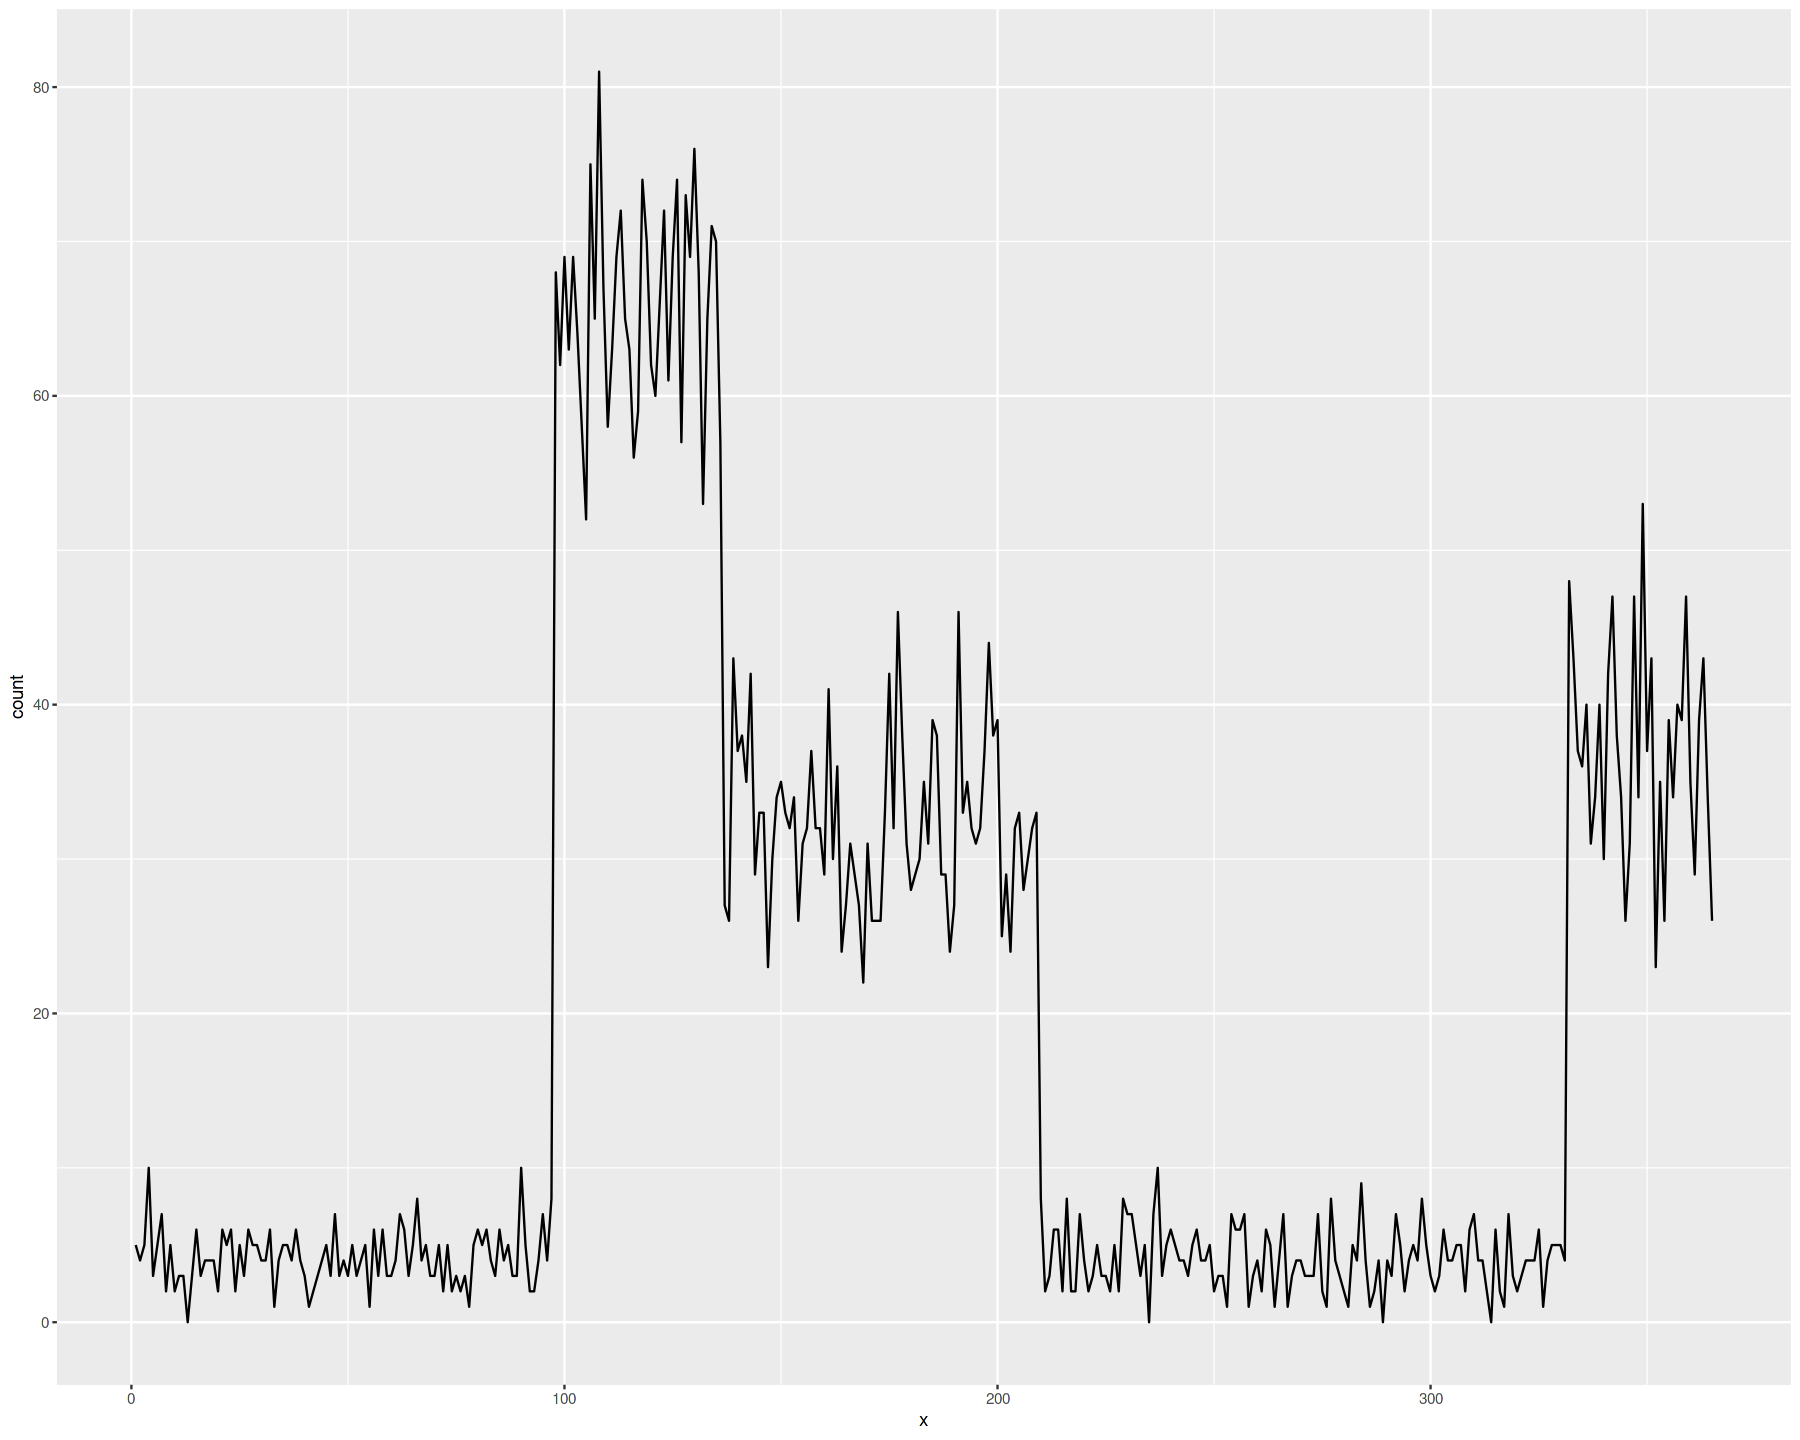

In [5]:
ggplot(data=data) + geom_line(mapping=aes(x=x, y=count))

We use the changepoint package to fit this data:

In [6]:
str(cpt.meanvar(data$count, method="PELT", test.stat="Poisson"))

Formal class 'cpt' [package "changepoint"] with 12 slots
  ..@ data.set : Time-Series [1:365] from 1 to 365: 5 4 5 10 3 5 7 2 5 2 ...
  ..@ cpttype  : chr "mean and variance"
  ..@ method   : chr "PELT"
  ..@ test.stat: chr "Poisson"
  ..@ pen.type : chr "MBIC"
  ..@ pen.value: num 17.7
  ..@ minseglen: num 2
  ..@ cpts     : int [1:5] 97 136 209 331 365
  ..@ ncpts.max: num Inf
  ..@ param.est:List of 1
  .. ..$ lambda: num [1:5] 4.19 65.77 32.23 4.07 37.06
  ..@ date     : chr "Mon Jun 22 15:25:13 2020"
  ..@ version  : chr "2.2.2"


That worked well with the changepoints exactly located where they were generated!

In practice the true distributions can have a large amount of overdispersion, so it's interesting to look at manual setting of the penalty. Let's look at the penalty vs. the number of changepoints:

In [7]:
get_nb_chgpts <- function(pen) {
    length(cpt.meanvar(data$count, method="PELT", penalty="Manual", pen.value=pen)@cpts-1)
}

ncpts <- data.table(penalty=1:500, nb_chgpts=sapply(1:500, get_nb_chgpts))

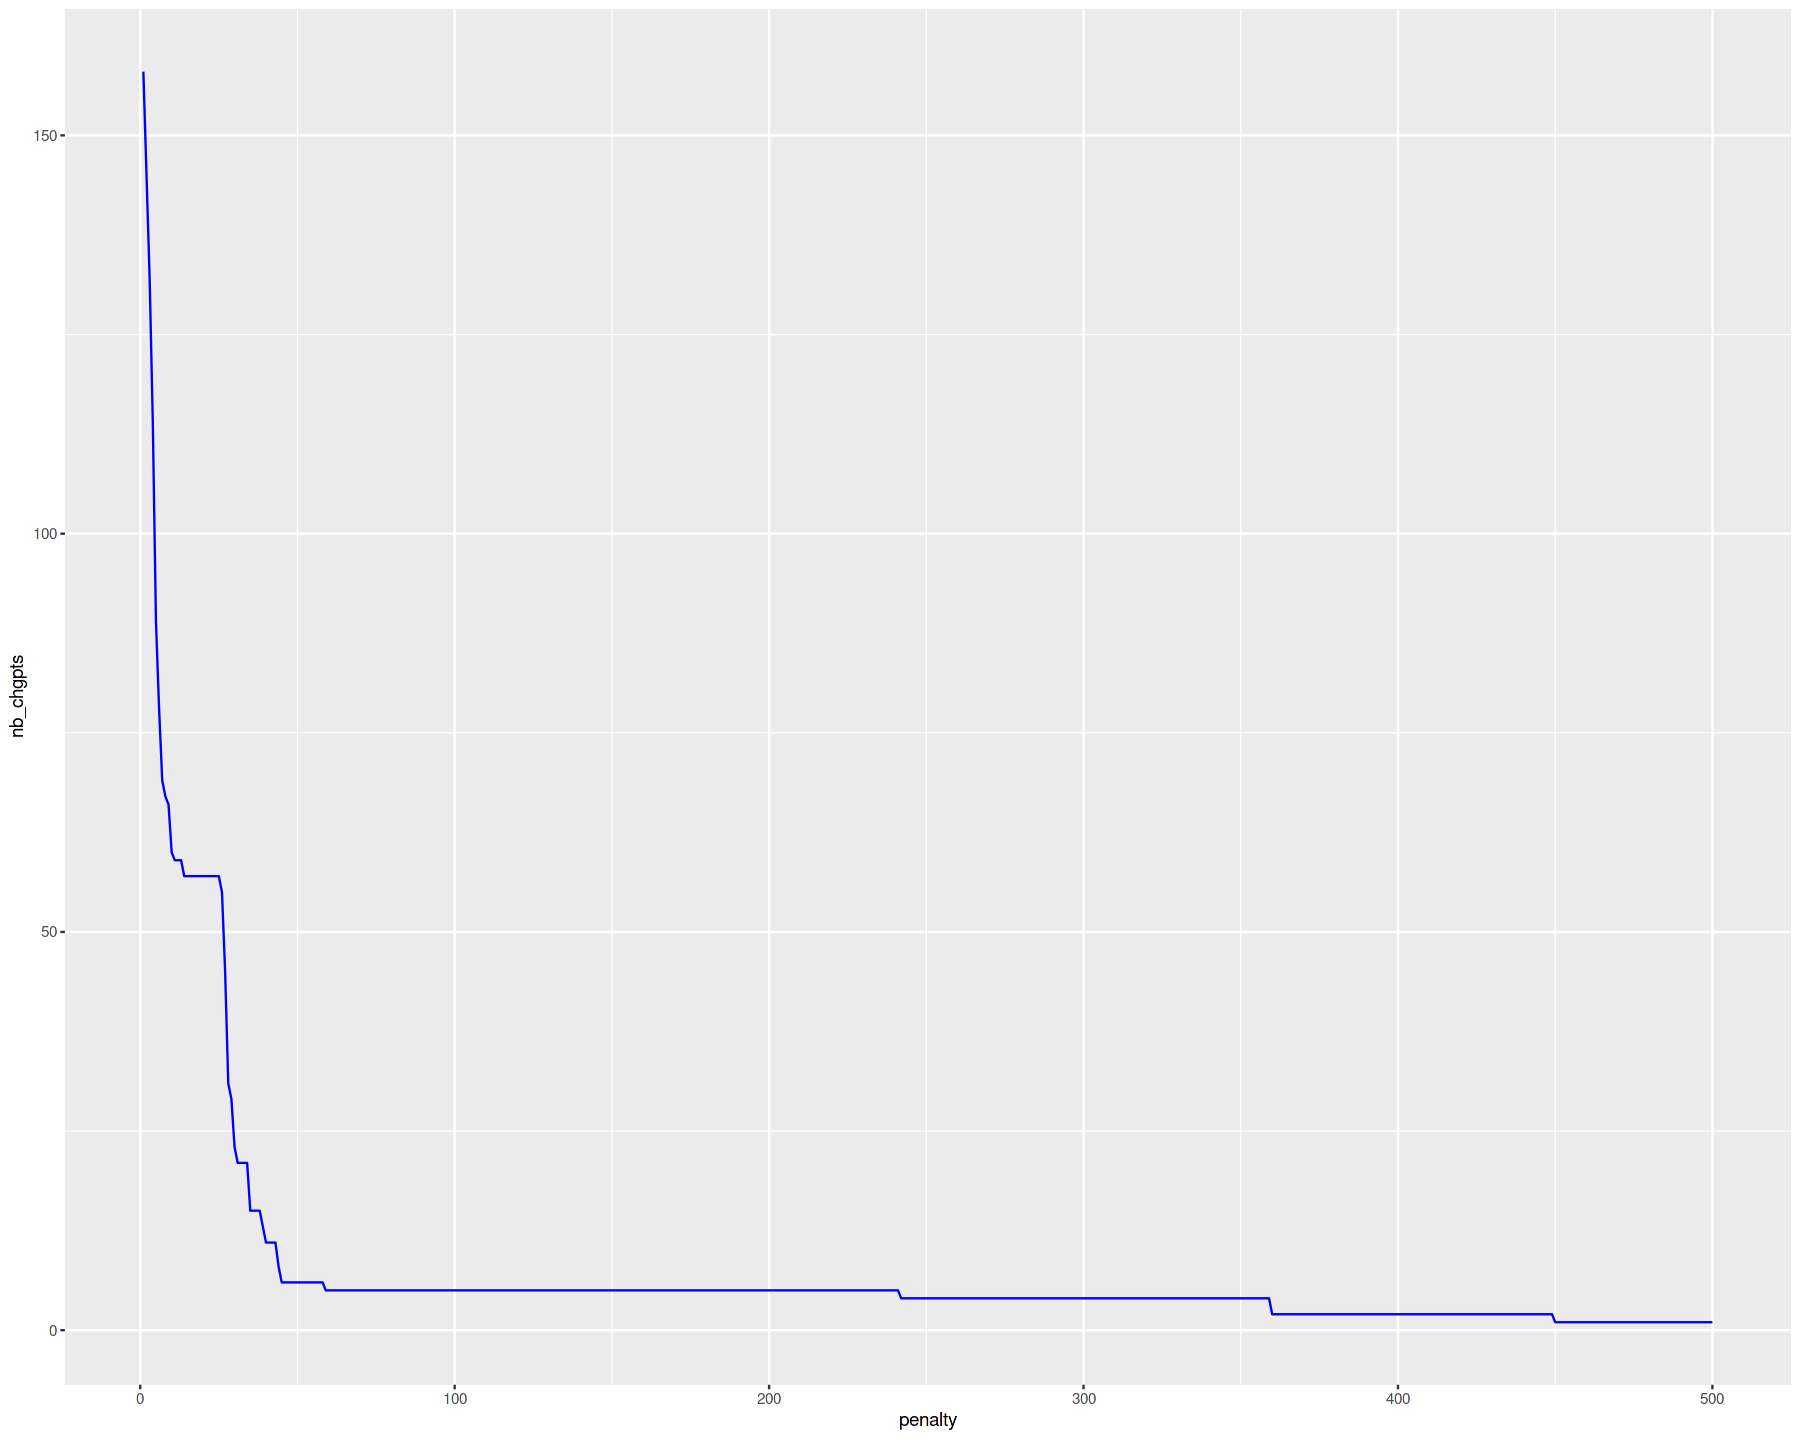

In [8]:
ggplot(ncpts, aes(x=penalty, y=nb_chgpts)) + geom_line(color="blue")

As usual, a good rule of thumb is to take the value at the point of stabilization, so here probably ~60.

Finally, let's plot the data and the changepoints.

In [9]:
chgpts <- cpt.meanvar(data$count, method="PELT", test.stat="Poisson")

In [10]:
augment_data <- function(data, chgpts) {
    fitted_period_lengths <- diff(c(0, chgpts@cpts))

    fitted_lambdas <- do.call(c, mapply(function(x, y) rep(x, y), chgpts@param.est$lambda, fitted_period_lengths))
    data.table(data, fitted_lambdas=fitted_lambdas)        
}

In [11]:
graph_all <- function(data, chgpts) {
    augmented_data <- augment_data(data, chgpts)
    ggplot(data=augmented_data) + geom_line(mapping=aes(x=x, y=count, group=period_nb, color=period_nb)) +
        geom_line(mapping=aes(x=x, y=fitted_lambdas), color="red") +
        theme(legend.position="none")
}

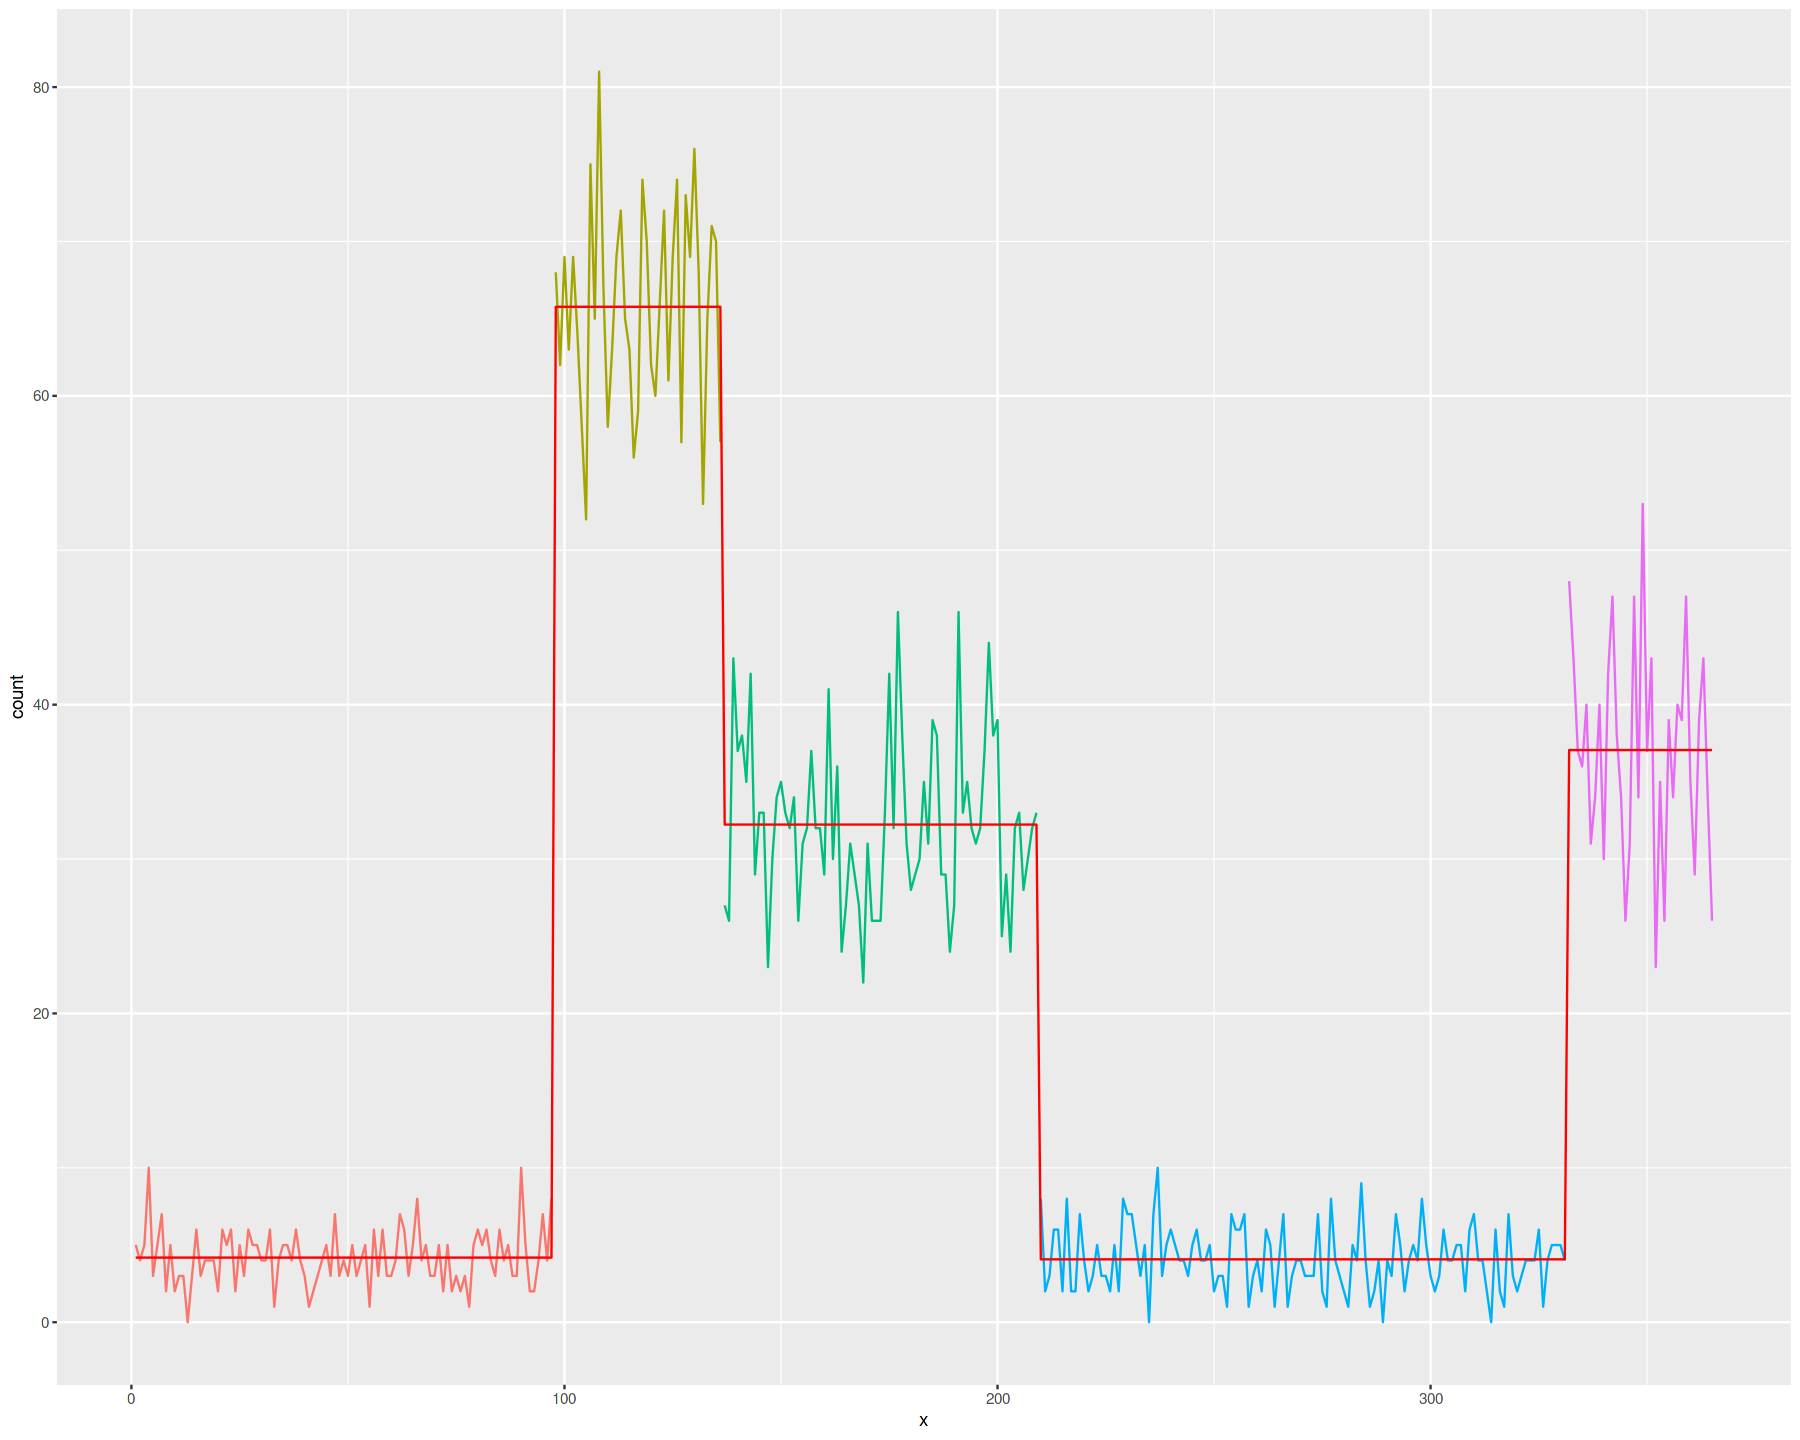

In [12]:
graph_all(data, chgpts)

## Example 2

In this example we use the same paramters as in example 1 except that we lower the variance of the normal distribution from which we chose the poisson `lambda` parameter. This means that the data will not have as clear-cut changes as in example 1, and we expect the algorithm to have more difficulty in finding the changepoints.

In [13]:
sigma <- 5  # sigma was 25 in the previous example

generative_data2 <- make_generative_data(N, np, mu, sigma, seed=0)
generative_data2

period_nb,period_start,period_end,period_length,lambda
<fct>,<dbl>,<dbl>,<dbl>,<int>
1,0,97,97,31
2,97,136,39,31
3,136,209,73,27
4,209,327,118,17
5,327,365,38,20


In [14]:
data2 <- data.table(x=1:N, generative_data2[, generate(.SD), by=period_nb])

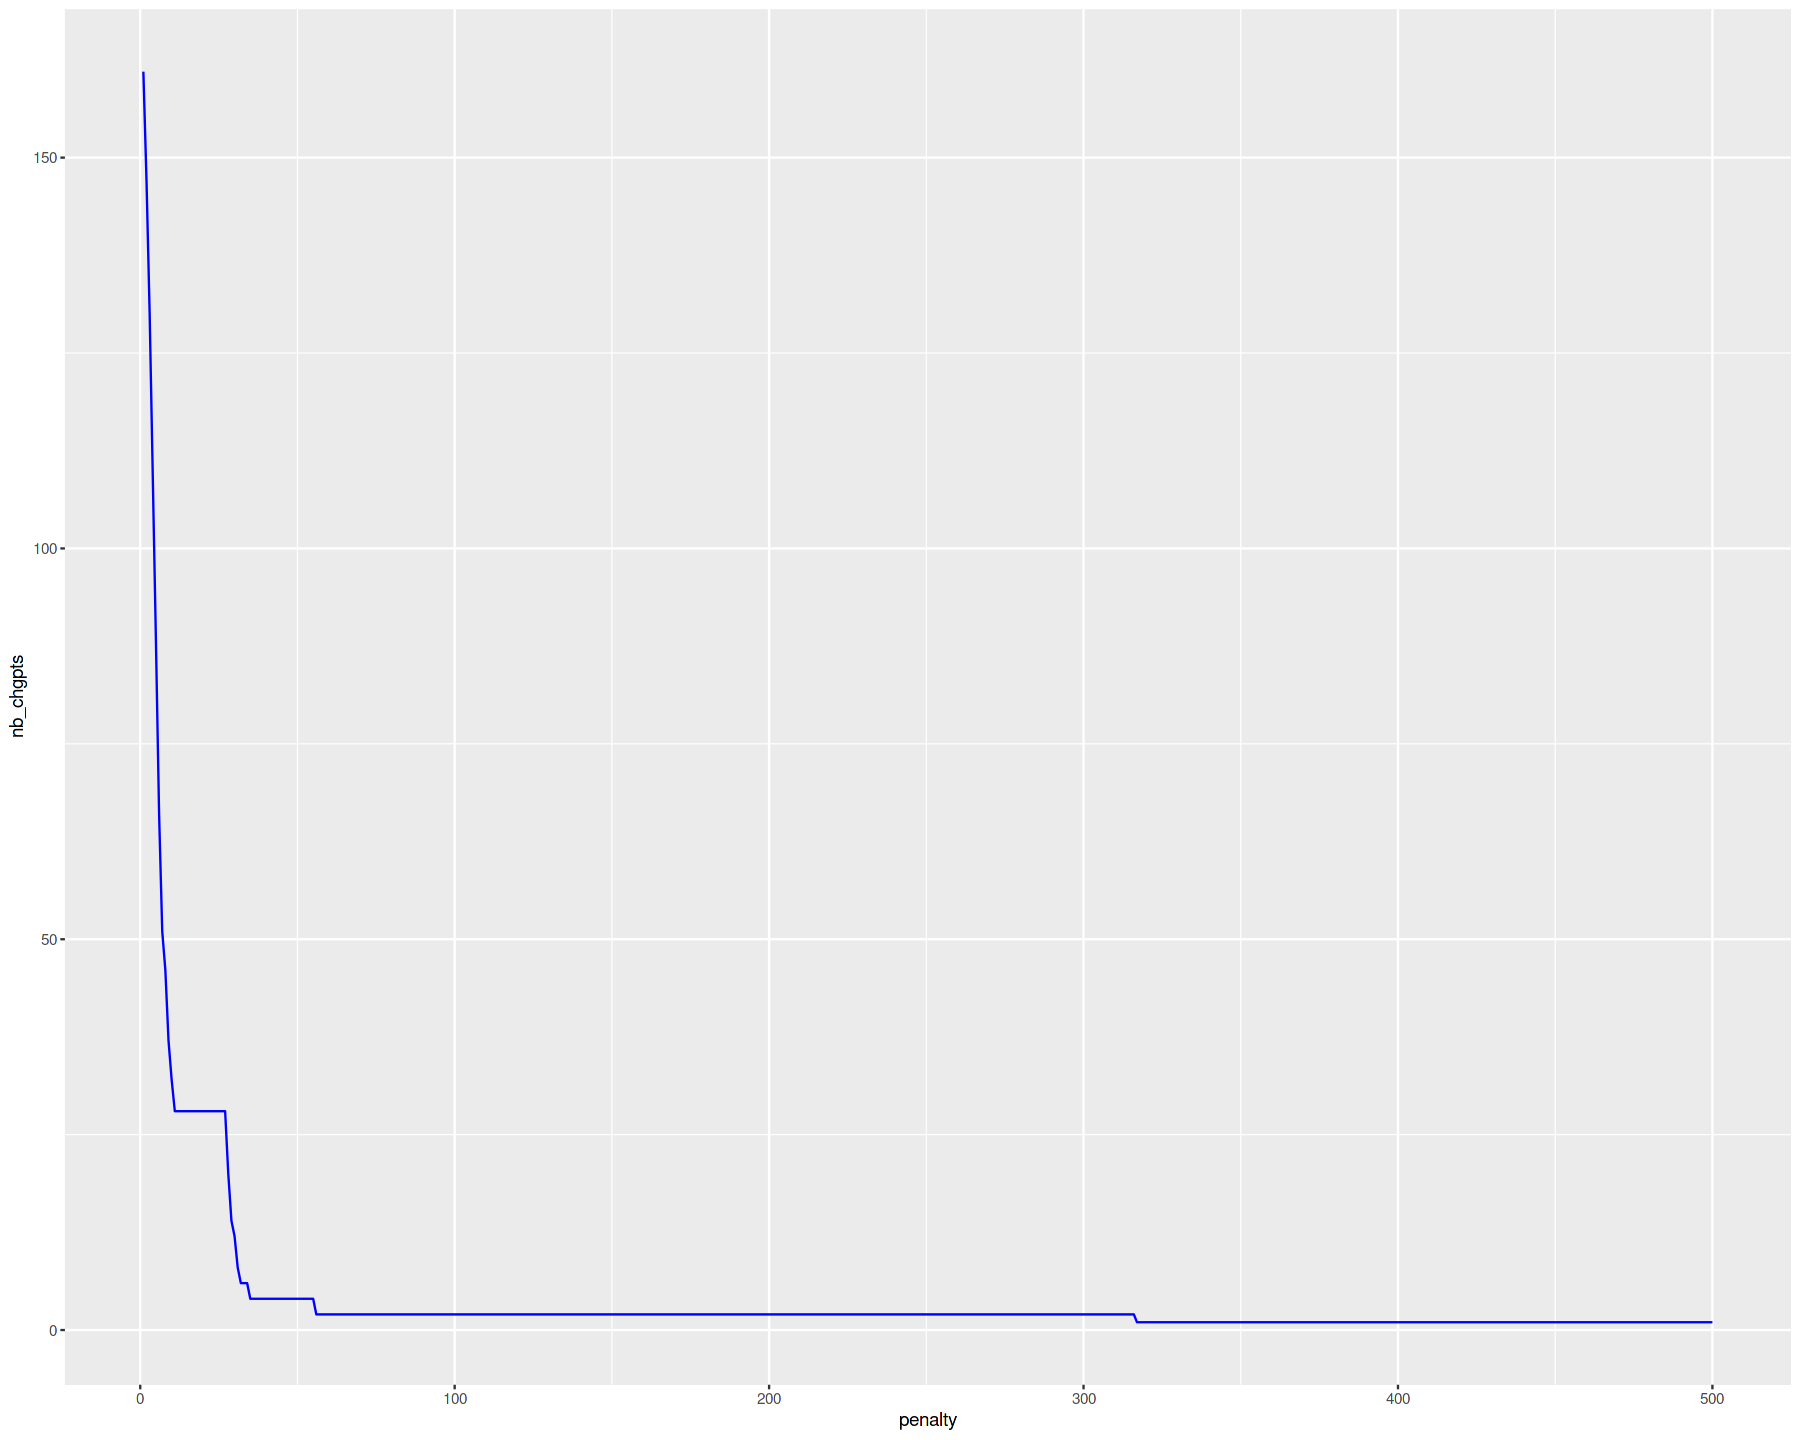

In [15]:
get_nb_chgpts2 <- function(pen) {
    length(cpt.meanvar(data2$count, method="PELT", penalty="Manual", pen.value=pen)@cpts)
}

ncpts2 <- data.table(penalty=1:500, nb_chgpts=sapply(1:500, get_nb_chgpts2))
ggplot(ncpts2, aes(x=penalty, y=nb_chgpts)) + geom_line(color="blue")

In [16]:
chgpts2 <- cpt.meanvar(data2$count, method="PELT", test.stat="Poisson")
str(chgpts2)

Formal class 'cpt' [package "changepoint"] with 12 slots
  ..@ data.set : Time-Series [1:365] from 1 to 365: 29 30 44 35 26 27 29 28 30 36 ...
  ..@ cpttype  : chr "mean and variance"
  ..@ method   : chr "PELT"
  ..@ test.stat: chr "Poisson"
  ..@ pen.type : chr "MBIC"
  ..@ pen.value: num 17.7
  ..@ minseglen: num 2
  ..@ cpts     : int [1:3] 145 206 365
  ..@ ncpts.max: num Inf
  ..@ param.est:List of 1
  .. ..$ lambda: num [1:3] 30.8 25.8 17.4
  ..@ date     : chr "Mon Jun 22 15:25:13 2020"
  ..@ version  : chr "2.2.2"


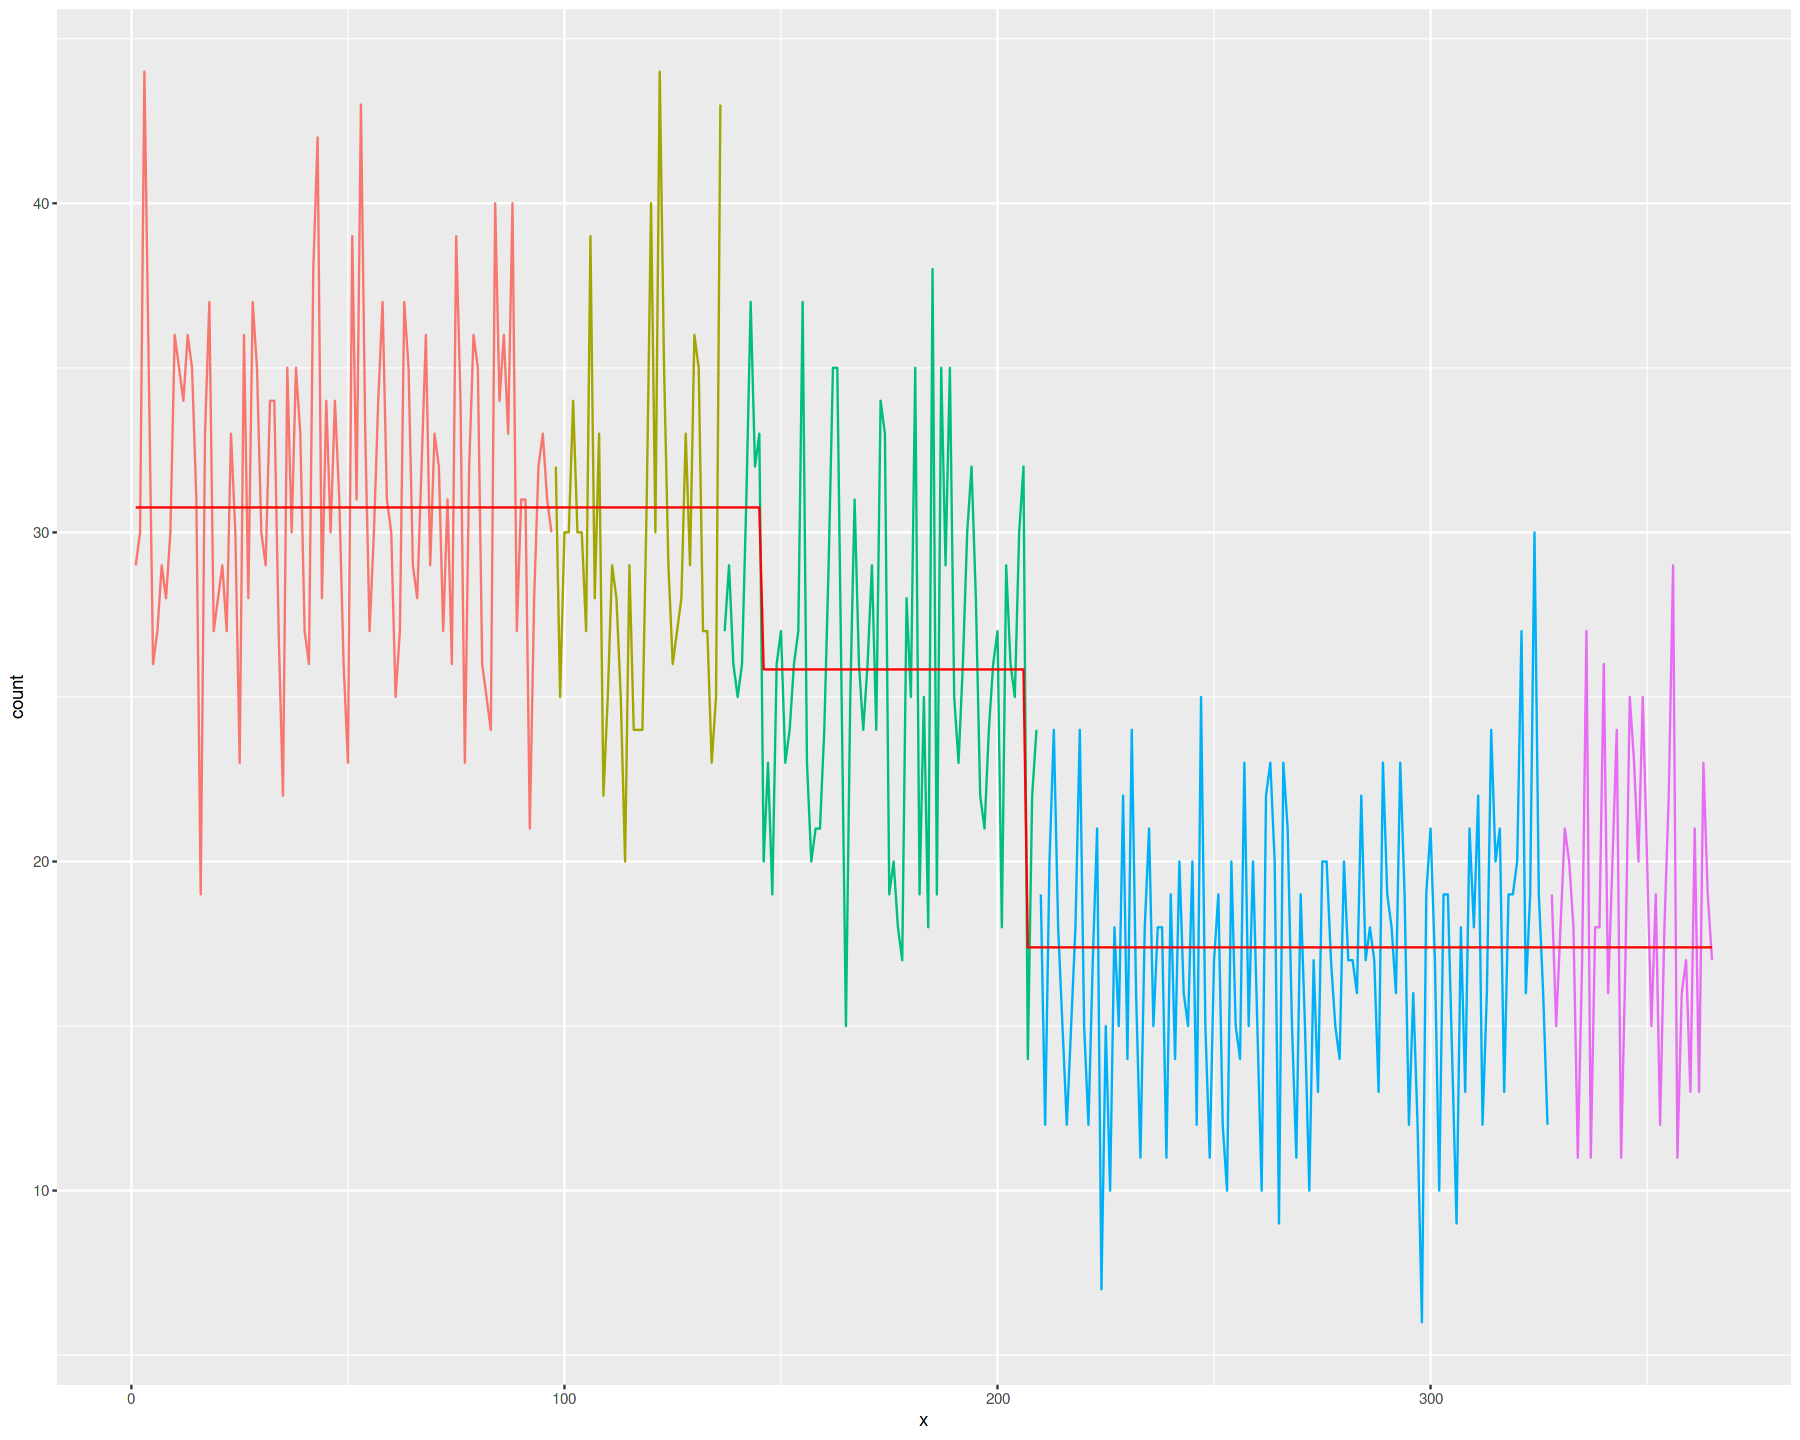

In [17]:
graph_all(data2, chgpts2)

# How it works

## Binary segmentation

## Optimal partitioning

## PELT